In [2]:
# External Libraries
import skimage.io
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans

# Builtin libraries
import os
import math
import json
import time
import pathlib
import zipfile
import itertools
import functools
import collections
import concurrent.futures
from pprint import pprint
from threading import RLock

## nonogramize the image using PIL (old)

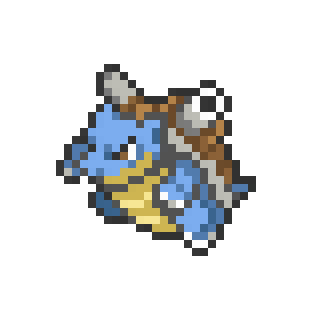

In [2]:
im = Image.open("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")

im = im.convert("RGBA", palette=Image.ADAPTIVE, colors=256)
# im = im.convert('P', palette=Image.WEB, colors=12)
# im = im.convert('P', dither=Image.NONE, palette=Image.ADAPTIVE, colors=5)
# im = im.convert("RGBA", palette=Image.ADAPTIVE, colors=256)
pix = im.load()
W, H = im.size

# Resize to view
ratio = math.ceil(300/W)
im.resize([W * ratio, H * ratio], resample=Image.NEAREST)

#### Find start and end row/col

In [3]:
# First and Last Row/Column
f_row = l_row = f_col = l_col = None
for y in range(H):
    for x in range(W):
        if pix[x, y] == (255, 255, 255, 0): continue
        if not f_row: f_row = y
        l_row = y
        if not f_col or x < f_col: f_col = x
        if not l_col or x > l_col: l_col = x
print(f_row, l_row, f_col, l_col)

8 31 7 31


In [4]:
# Count color freq
rows_count = {}
for y in range(f_row, l_row + 1):
    count = []
    row = []
    for x in range(f_col, l_col + 1):
        p = pix[x, y]
        row.append("#%02x%02x%02x%02x"%(p[0], p[1], p[2], p[3]))
    for k, grp in itertools.groupby(row):
        count.append((k, len(list(grp))))
    rows_count[y] = count
    
for k, count in rows_count.items():
    rows_count[k] = list(filter(lambda x: x[0] != "#ffffff00", count))
pprint(rows_count, compact=True)

{8: [('#363636ff', 1), ('#313131ff', 1)],
 9: [('#363636ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#333333ff', 1)],
 10: [('#363636ff', 1), ('#babab2ff', 1), ('#bdbdb5ff', 2), ('#333333ff', 1),
      ('#363636ff', 1), ('#313131ff', 1)],
 11: [('#353535ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#bdbdb5ff', 2),
      ('#333333ff', 1), ('#353535ff', 1), ('#313131ff', 3), ('#fbfbfbff', 1),
      ('#ffffffff', 1), ('#343434ff', 1)],
 12: [('#363636ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#8c643aff', 1),
      ('#6b4a29ff', 1), ('#313130ff', 1), ('#313131ff', 2), ('#b28249ff', 1),
      ('#6c4a29ff', 1), ('#525151ff', 1), ('#fcfcfcff', 1), ('#343434ff', 1),
      ('#313131ff', 1), ('#fbfbfbff', 1), ('#343434ff', 1)],
 13: [('#353535ff', 1), ('#79abecff', 1), ('#323233ff', 1), ('#8a6238ff', 1),
      ('#6b4a29ff', 1), ('#b38349ff', 1), ('#b5844aff', 1), ('#6c4a29ff', 1),
      ('#b38349ff', 1), ('#6c4a29ff', 1), ('#525151ff', 1), ('#bbbbb3ff', 1),
      ('#fdfdfdff', 1), ('#3434

## nonogramize the image using skimage and np

In [33]:
def reduce_color_palette(im, n_colors=8, n_init=256, max_iter=500, tol=0.00001):
    """
    Reduce color palette using K-means
    n_colors: number of colors in the final image
    """
    im = np.copy(im)
    # Transform image to array
    w,h,z = im.shape
    im = im.reshape(w*h,z)
    
    # Train model
    kmeans = KMeans(n_clusters=n_colors, 
                    n_init=n_init, 
                    max_iter=max_iter, 
                    tol=tol,
                    random_state=0,
                   ).fit(im)
    
    # find out which cluster each pixel belongs to.
    labels = kmeans.predict(im)
    
    # the cluster centroids is our color palette
    identified_palette = np.array(kmeans.cluster_centers_).astype(int)
    
    # recolor the entire image
    recolored_img = np.copy(im)
    for index in range(len(im)):
        im[index] = identified_palette[labels[index]]
    
    # reshape for display
    im = im.reshape(w,h,z)
    
    return im

def get_colored_pixel_rectangle(im):
    """
    return First Row, Last Row, First Column, Last Column as a tuple
    """
    f_row = l_row = f_col = l_col = None
    for r, row in enumerate(im):
        for c, p in enumerate(row):
            pixel = "#" + "".join(f"{c:02x}" for c in p)
            if pixel[1:6:2] == "fff": continue
            if pixel[1:6:2] == "000": continue
            if not f_row: f_row = r
            l_row = r
            if not f_col or c < f_col: f_col = c
            if not l_col or c > l_col: l_col = c
    return (f_row, l_row, f_col, l_col)

def get_row_counts(im, dim):
    """
    return the the groupby() of rows as dictionary
    """
    f_row, l_row, *_ = dim
    rows_count = {}
    for r in range(f_row, l_row + 1):
        count = []
        row =["#" + "".join(f"{c:02x}" for c in p) for p in im[r,:]]
        for k, grp in itertools.groupby(row):
            count.append((k, len(list(grp))))
        rows_count[r] = count

    for k, count in rows_count.items():
        rows_count[k] = list(filter(lambda x:x[0][1:6:2] not in ("fff", "000"), 
                                    count))
    return rows_count

def get_col_counts(im, dim):
    """
    return the the groupby() of cols as dictionary
    """
    *_, f_col, l_col = dim
    cols_count = {}
    for c in range(f_col, l_col + 1):
        count = []
        col =["#" + "".join(f"{c:02x}" for c in p) for p in im[:,c]]
        for k, grp in itertools.groupby(col):
            count.append((k, len(list(grp))))
        cols_count[c] = count

    for k, count in cols_count.items():
        cols_count[k] = list(filter(lambda x:x[0][1:6:2] not in ("fff", "000"), 
                                    count,))
    return cols_count

def generate_nonogram_by_size(image_path, verbose=False):
    """
    Creating nonogram for 1 image
    """
    image = skimage.io.imread(image_path)[:,:,:-1] # to Exclude alpha
    nonogram_by_ncolor = {}
    for n_color in (3, 5, 7):
        im = reduce_color_palette(image, n_colors=n_color, n_init=256, max_iter=500, tol=1e-05)
        dim = get_colored_pixel_rectangle(im)
        rows_count = get_row_counts(im, dim)
        cols_count = get_col_counts(im, dim)
        nonogram_by_ncolor[n_color] = [rows_count, cols_count]
    
#     with lock:
#         nonogram[image_path.rsplit("/",1)[-1]]=nonogram_by_ncolor
    if verbose:
        print(f"Done with {image_path}")
    return nonogram_by_ncolor


def multithread(image_paths=[], no_threads=16, verbose=False):
    """
    Multithreading creating nonogram
    """
    nonogram = {}
    lock = RLock()
    with concurrent.futures.ThreadPoolExecutor(max_workers=no_threads) as executor:
        partial_func = functools.partial(generate_nonogram_by_size, nonogram=nonogram, lock=lock, verbose=verbose)
        executor.map(partial_func, image_paths)
    return nonogram

# Test Run

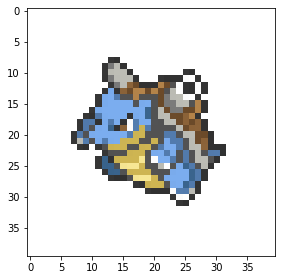

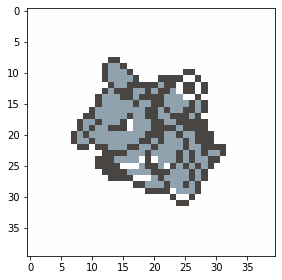

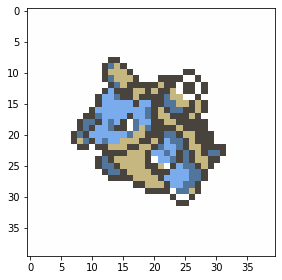

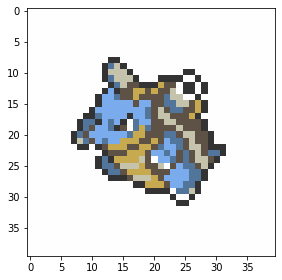

{3: [{8: [('#484542', 2)],
   9: [('#484542', 1), ('#90a2ad', 2), ('#484542', 1)],
   10: [('#484542', 1), ('#90a2ad', 3), ('#484542', 1), ('#484542', 2)],
   11: [('#484542', 1),
    ('#90a2ad', 4),
    ('#484542', 1),
    ('#484542', 4),
    ('#484542', 1)],
   12: [('#484542', 1),
    ('#90a2ad', 2),
    ('#484542', 5),
    ('#90a2ad', 1),
    ('#484542', 2),
    ('#484542', 2),
    ('#484542', 1)],
   13: [('#484542', 1),
    ('#90a2ad', 1),
    ('#484542', 3),
    ('#90a2ad', 2),
    ('#484542', 1),
    ('#90a2ad', 1),
    ('#484542', 2),
    ('#90a2ad', 1),
    ('#484542', 2),
    ('#484542', 1)],
   14: [('#484542', 1),
    ('#90a2ad', 3),
    ('#484542', 2),
    ('#90a2ad', 1),
    ('#484542', 4),
    ('#90a2ad', 3),
    ('#484542', 1)],
   15: [('#484542', 1),
    ('#90a2ad', 5),
    ('#484542', 1),
    ('#90a2ad', 2),
    ('#484542', 2),
    ('#90a2ad', 4),
    ('#484542', 1),
    ('#90a2ad', 1),
    ('#484542', 1)],
   16: [('#484542', 1),
    ('#90a2ad', 8),
    ('#484542',

In [32]:
im = skimage.io.imread("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")
skimage.io.imshow(im)
skimage.io.show()
for no in 3, 5, 7:
    im1 = reduce_color_palette(im[:,:,:-1], no) # im[:,:,:-1] to Exclude alpha
    skimage.io.imshow(im1)
    skimage.io.show()
generate_nonogram_by_size("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")

# Actual Run

In [34]:
db_path = "../DataScraping/data/pokemon_sprites_bulbapedia/"
nonogram = {}
for file in os.listdir(db_path):
    nonogram_by_ncolor = generate_nonogram_by_size(db_path + file, True)
    nonogram[file] = nonogram_by_ncolor
print(f"Finish nonogramize all sprites")

Done with ../DataScraping/data/pokemon_sprites_bulbapedia/001_Bulbasaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/002_Ivysaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/003_Venusaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/004_Charmander.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/005_Charmeleon.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/006_Charizard.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/007_Squirtle.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/008_Wartortle.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/010_Caterpie.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/011_Metapod.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/012_Butterfree.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/013_Weedle.png
Done with ../DataSc

In [35]:
with open("./data/info.json", "w") as f:
    json.dump(nonogram, f)